<a href="https://colab.research.google.com/github/louiscam/systemic-activation/blob/main/PowerAnalysis_NerveExperiment_081820_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [ ]:
# Install relevant packages
Sys.setenv(PATH= paste("/conda/bin" , Sys.getenv("PATH"), sep = ":" ) )
install.packages('reshape2', repos='http://cran.rstudio.com/')
install.packages('lme4', repos='http://cran.rstudio.com/')
install.packages('lmerTest', repos='http://cran.rstudio.com/')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘numDeriv’




In [ ]:
# Imports
require(tidyverse)
require(reshape2)
require(ggplot2)
require(lme4)
require(lmerTest)

# Load and clean pilot study data

In [ ]:
# We hard code the pilot study data for simplicity
data_string = 
"FileName_Input,Math_Percent_EdU
D10_C1_RGB.tif,3.233095776
D10_C2_RGB.tif,1.712558764
D1_C1_RGB.tif,0.825309491
D1_C2_RGB.tif,0.567241787
D2_C1_RGB.tif,2.520808561
D2_C2_RGB.tif,3.038010456
D3_C1_RGB.tif,1.41607184
D3_C2_RGB.tif,1.59135265
D4_C_RGB.tif,3.193851409
D6_C1_RGB.tif,0.050598752
D6_C2_RGB.tif,0.191435768
D7_C1_RGB.tif,0.699650175
D7_C2_RGB.tif,5.017379477
D8_C1_RGB.tif,1.480484522
D8_C2_RGB.tif,2.10576693
D9_C1_RGB.tif,8.459776696
D9_C2_RGB.tif,4.446835216
S1_C1_RGB.tif,13.81414702
S1_C2_RGB.tif,17.96253528
S2_C1_RGB.tif,7.594179789
S2_C2_RGB.tif,8.927130949
S3_C1_RGB.tif,6.916005015
S3_C2_RGB.tif,7.418005723
S4_C1_RGB.tif,10.00370508
S4_C2_RGB.tif,5.429527705
S5_C1_RGB.tif,2.737890101
S5_C2_RGB.tif,2.158404975
S6_C1_RGB.tif,11.53230112
S6_C2_RGB.tif,9.061662198
S7_C1_RGB.tif,12.65192269
S7_C2_RGB.tif,16.0899654
S8_C1_RGB.tif,5.644988195
S8_C2_RGB.tif,14.95551815
S9_C1_RGB.tif,7.313540912
S9_C2_RGB.tif,6.879756469"

In [ ]:
# Create pilot study dataframe
nerve_df = read.table(text=data_string,
                      sep=",",
                      header = TRUE,
                      stringsAsFactors=FALSE)
# Rename columns
colnames(nerve_df) = c('id','edu_pct')

In [ ]:
# Annotate forelimb and hindlimb
nerve_df$id = str_remove(nerve_df$id,'_RGB.tif')
nerve_df = separate(data=nerve_df, col='id', into=c('animal_id','limb'), sep='_', remove=TRUE)
nerve_df$limb = str_replace(string=nerve_df$limb, pattern='C1', replacement='forelimb')
nerve_df$limb = str_replace(string=nerve_df$limb, pattern='C2', replacement='hindlimb')
nerve_df$limb = str_replace(string=nerve_df$limb, pattern='C', replacement='unknown')

In [ ]:
# Annotate sham and control animals
nerve_df$animal_id = str_replace(string=nerve_df$animal_id, pattern='S', replacement='S_')
nerve_df$animal_id = str_replace(string=nerve_df$animal_id, pattern='D', replacement='D_')
nerve_df = separate(data=nerve_df, col='animal_id', into=c('group','animal'), sep='_', remove=FALSE)
nerve_df$group = str_replace(string=nerve_df$group, pattern='D', replacement='denervated')
nerve_df$group = str_replace(string=nerve_df$group, pattern='S', replacement='sham')

In [ ]:
# Create dataframes for sham and denervated animals
sham_df = nerve_df[nerve_df$group=='sham',]
sham_df['normalized_edu'] = scale(sham_df$edu_pct)
denervated_df = nerve_df[nerve_df$group=='denervated',]
denervated_df['normalized_edu'] = scale(denervated_df$edu_pct)

# Exploratory data analysis

## Limb dependence

[1] 0.7989448


	Kendall's rank correlation tau

data:  limb_df$edu_forelimb and limb_df$edu_hindlimb
T = 112, p-value = 0.0001277
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.6470588 


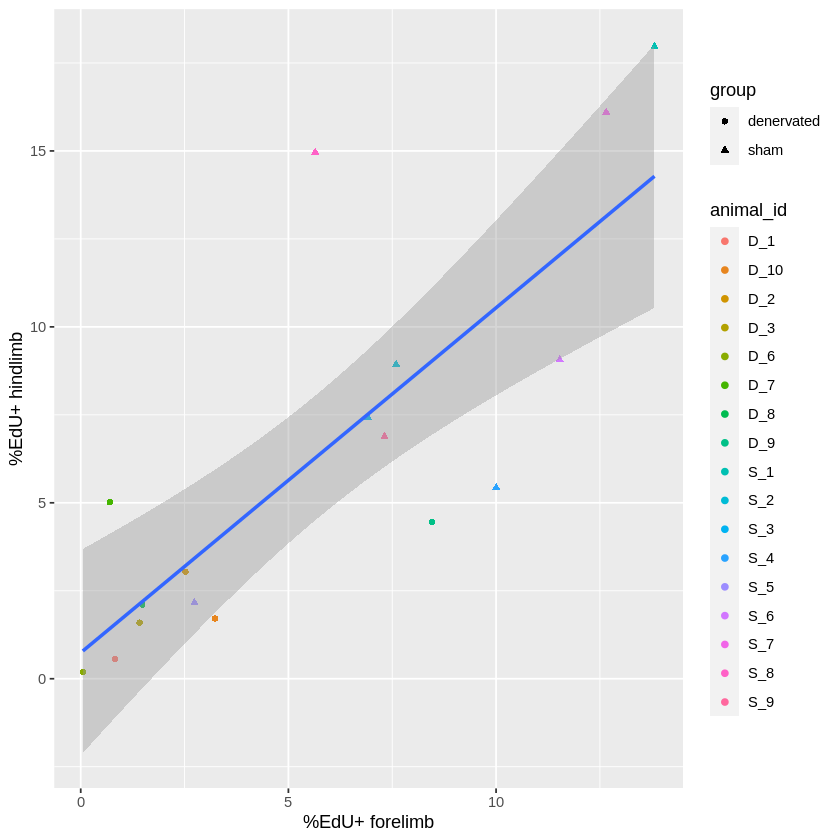

In [ ]:
# Test independence of limbs data
forelimb_df = nerve_df[nerve_df['limb']=='forelimb',c(1,2,3,5)]
hindlimb_df = nerve_df[nerve_df['limb']=='hindlimb',c(1,5)]
limb_df = plyr::join(forelimb_df, hindlimb_df, by='animal_id', type='inner')
colnames(limb_df)[c(4,5)] = c('edu_forelimb', 'edu_hindlimb')
limb_df %>%
  ggplot(aes(x=edu_forelimb, y=edu_hindlimb))+
  geom_point(aes(col=animal_id, shape=group))+
  geom_smooth(method='lm', formula = y~x)+
  xlab('%EdU+ forelimb')+
  ylab('%EdU+ hindlimb')
cor(x=limb_df$edu_forelimb,y=limb_df$edu_hindlimb)
cor.test(x=limb_df$edu_forelimb, y=limb_df$edu_hindlimb, alternative='two.sided', method='kendall', exact=NULL)

## Forelimb and hindlimb response distribution

In [ ]:
# Analysis for fore and hindlimbs for sham
summary(sham_df$edu_pct[sham_df$limb=='forelimb'])
summary(sham_df$edu_pct[sham_df$limb=='hindlimb'])
ks.test(x=sham_df$edu_pct[sham_df$limb=='forelimb'],y=sham_df$edu_pct[sham_df$limb=='hindlimb'], alternative='two.sided', exact=TRUE)
wilcox.test(x=sham_df$edu_pct[sham_df$limb=='forelimb'],y=sham_df$edu_pct[sham_df$limb=='hindlimb'], alternative='two.sided', paired=TRUE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.738   6.916   7.594   8.690  11.532  13.814 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.158   6.880   8.927   9.876  14.956  17.963 


	Two-sample Kolmogorov-Smirnov test

data:  sham_df$edu_pct[sham_df$limb == "forelimb"] and sham_df$edu_pct[sham_df$limb == "hindlimb"]
D = 0.33333, p-value = 0.7301
alternative hypothesis: two-sided



	Wilcoxon signed rank test

data:  sham_df$edu_pct[sham_df$limb == "forelimb"] and sham_df$edu_pct[sham_df$limb == "hindlimb"]
V = 17, p-value = 0.5703
alternative hypothesis: true location shift is not equal to 0


In [ ]:
# Analysis for fore and hindlimbs for denervated
summary(denervated_df$edu_pct[denervated_df$limb=='forelimb'])
summary(denervated_df$edu_pct[denervated_df$limb=='hindlimb'])
ks.test(x=denervated_df$edu_pct[denervated_df$limb=='forelimb'],y=denervated_df$edu_pct[denervated_df$limb=='hindlimb'], alternative='two.sided', exact=TRUE)
wilcox.test(x=denervated_df$edu_pct[denervated_df$limb=='forelimb'],y=denervated_df$edu_pct[denervated_df$limb=='hindlimb'], alternative='two.sided', paired=TRUE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0506  0.7939  1.4483  2.3357  2.6989  8.4598 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1914  1.3353  1.9092  2.3338  3.3902  5.0174 


	Two-sample Kolmogorov-Smirnov test

data:  denervated_df$edu_pct[denervated_df$limb == "forelimb"] and denervated_df$edu_pct[denervated_df$limb == "hindlimb"]
D = 0.375, p-value = 0.6601
alternative hypothesis: two-sided



	Wilcoxon signed rank test

data:  denervated_df$edu_pct[denervated_df$limb == "forelimb"] and denervated_df$edu_pct[denervated_df$limb == "hindlimb"]
V = 16, p-value = 0.8438
alternative hypothesis: true location shift is not equal to 0


## Variance discrepancy

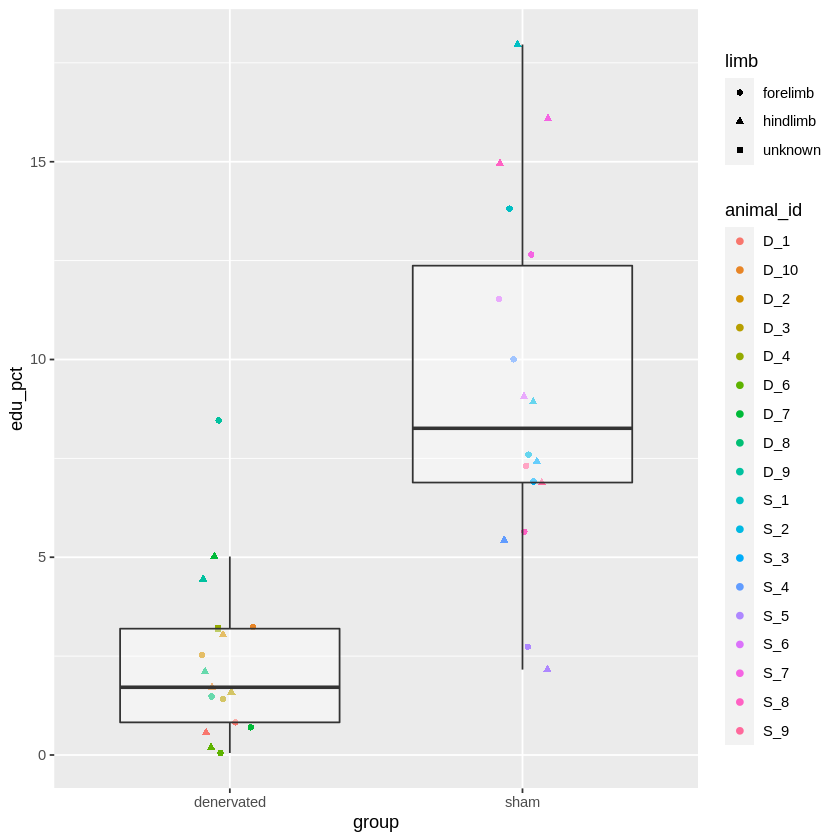

In [ ]:
# Plot both sham and denervated on the same plot, colored by animal and shaped by limb
nerve_df %>%
  group_by(group)%>%
  ggplot() +
  geom_jitter(aes(x=group, y=edu_pct, col=animal_id, shape=limb), height = 0, width=0.1) +
  geom_boxplot(aes(x=group, y=edu_pct), alpha=0.4, outlier.shape = NA)

In [ ]:
# Mean and standard deviation of the reponse
nerve_df %>%
  group_by(group)%>%
  summarise(mean_edu=mean(edu_pct),
            sd_edu=sd(edu_pct))

`summarise()` ungrouping output (override with `.groups` argument)



group,mean_edu,sd_edu
<chr>,<dbl>,<dbl>
denervated,2.385308,2.116266
sham,9.282844,4.437487


In [ ]:
# F-test for equality of variance (aggregated observations)
var.test(x=sham_df$edu_pct, y=denervated_df$edu_pct, ratio=1, alternative='two.sided')


	F test to compare two variances

data:  sham_df$edu_pct and denervated_df$edu_pct
F = 4.3968, num df = 17, denom df = 16, p-value = 0.004824
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  1.605834 11.857060
sample estimates:
ratio of variances 
           4.39677 


In [ ]:
# Create mean-aggregated data
nerve_df_agg = nerve_df %>%
  group_by(animal_id,group) %>%
  summarize(mean_edu = mean(edu_pct))
denervated_agg_df = nerve_df_agg[nerve_df_agg$group=='denervated',]
denervated_agg_df['normalized_edu'] = scale(denervated_agg_df$mean_edu)
sham_agg_df = nerve_df_agg[nerve_df_agg$group=='sham',]
sham_agg_df['normalized_edu'] = scale(sham_agg_df$mean_edu)

`summarise()` regrouping output by 'animal_id' (override with `.groups` argument)



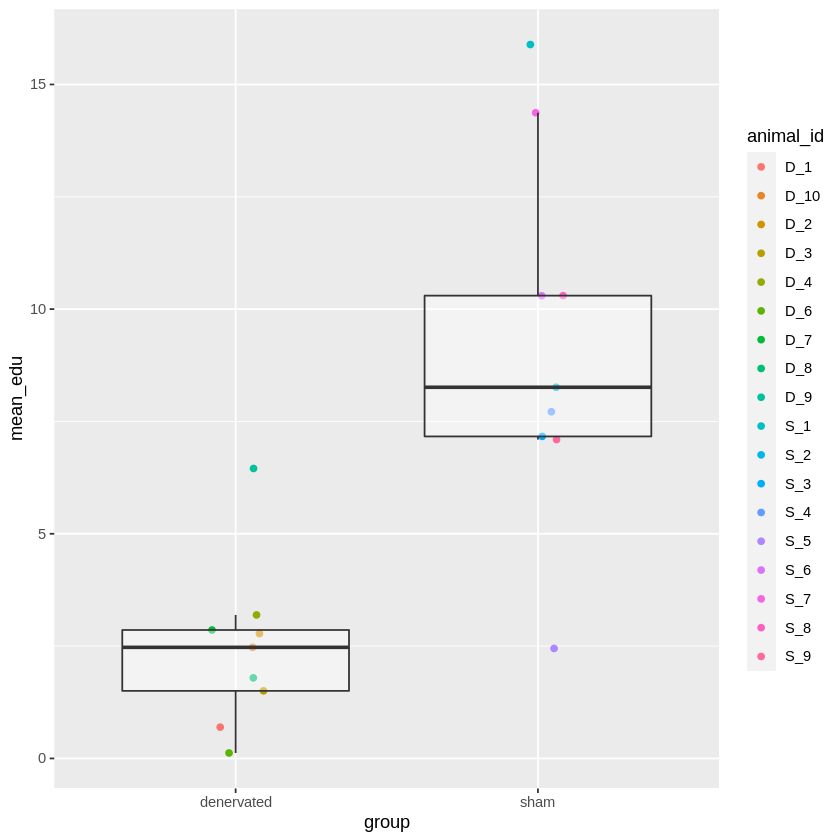

In [ ]:
# Plot both mean-aggregated sham and denervated on the same plot, colored by animal and shaped by limb
nerve_df_agg %>%
  group_by(group)%>%
  ggplot() +
  geom_jitter(aes(x=group, y=mean_edu, col=animal_id), height = 0, width=0.1) +
  geom_boxplot(aes(x=group, y=mean_edu), alpha=0.4, outlier.shape = NA)

In [ ]:
# Mean and standard deviation of the response
nerve_df_agg %>%
  group_by(group)%>%
  summarise(mean_mean_edu=mean(mean_edu),
            sd_mean_edu=sd(mean_edu))

`summarise()` ungrouping output (override with `.groups` argument)



group,mean_mean_edu,sd_mean_edu
<chr>,<dbl>,<dbl>
denervated,2.430227,1.826158
sham,9.282844,4.047409


In [ ]:
# F-test for equality of variance (aggregated observations)
var.test(x=sham_agg_df$mean_edu, y=denervated_agg_df$mean_edu, ratio=1, alternative='two.sided')


	F test to compare two variances

data:  sham_agg_df$mean_edu and denervated_agg_df$mean_edu
F = 4.9122, num df = 8, denom df = 8, p-value = 0.03715
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  1.108037 21.777137
sample estimates:
ratio of variances 
          4.912217 


## Normality


	One-sample Kolmogorov-Smirnov test

data:  sham_df$normalized_edu[sham_df$limb == "forelimb"]
D = 0.20379, p-value = 0.78
alternative hypothesis: two-sided


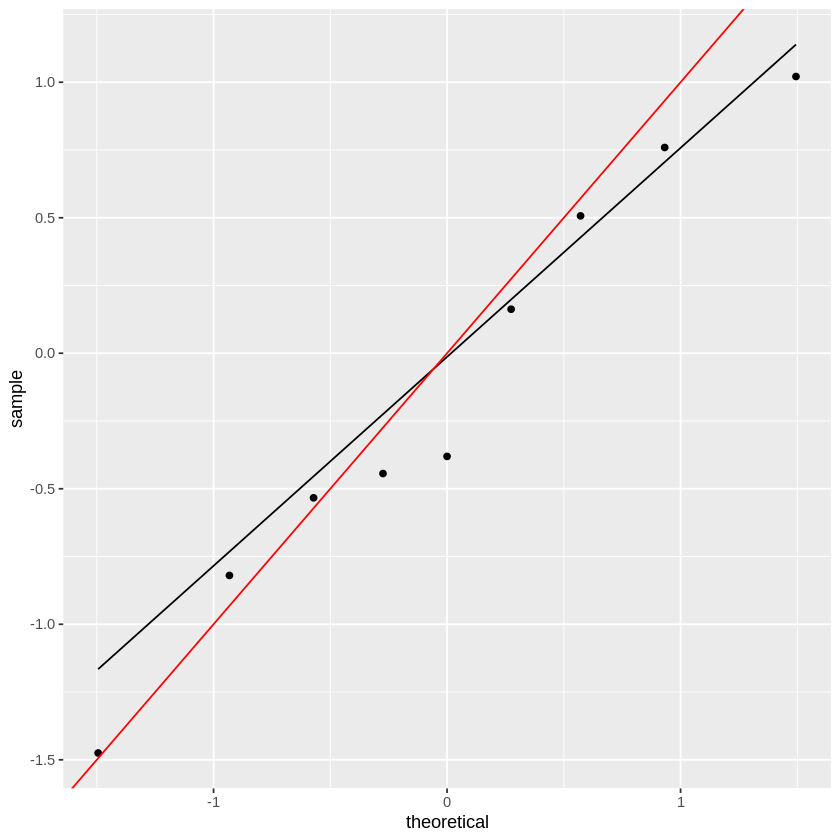

In [ ]:
# Sham forelimb data distribution
sham_df %>%
  filter(limb=='forelimb') %>% 
  ggplot(aes(sample=normalized_edu)) + 
  geom_qq() + geom_qq_line() + 
  geom_abline(slope=1, intercept=0, color='red')
ks.test(x=sham_df$normalized_edu[sham_df$limb=='forelimb'], y='pnorm', 0, 1, alternative='two.sided', exact=TRUE)


	One-sample Kolmogorov-Smirnov test

data:  sham_df$normalized_edu[sham_df$limb == "hindlimb"]
D = 0.23277, p-value = 0.634
alternative hypothesis: two-sided


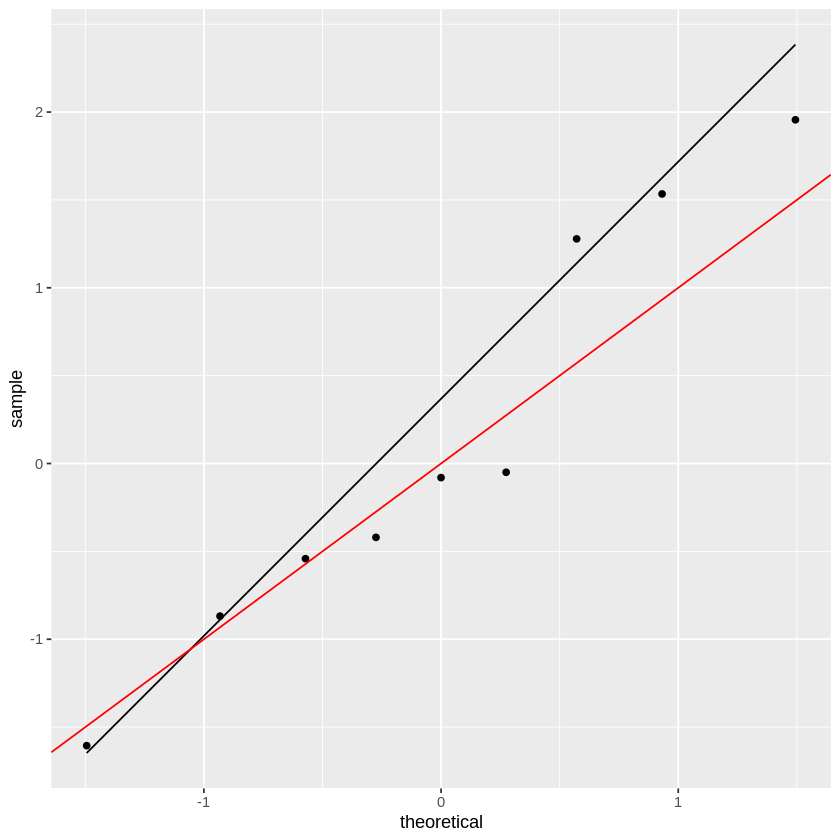

In [ ]:
# Sham hindlimb data distribution
sham_df %>%
  filter(limb=='hindlimb') %>% 
  ggplot(aes(sample=normalized_edu)) + 
  geom_qq() + geom_qq_line() + 
  geom_abline(slope=1, intercept=0, color='red')
ks.test(x=sham_df$normalized_edu[sham_df$limb=='hindlimb'], y='pnorm', 0, 1, alternative='two.sided', exact=TRUE)


	One-sample Kolmogorov-Smirnov test

data:  denervated_df$normalized_edu[denervated_df$limb == "forelimb"]
D = 0.29051, p-value = 0.4292
alternative hypothesis: two-sided


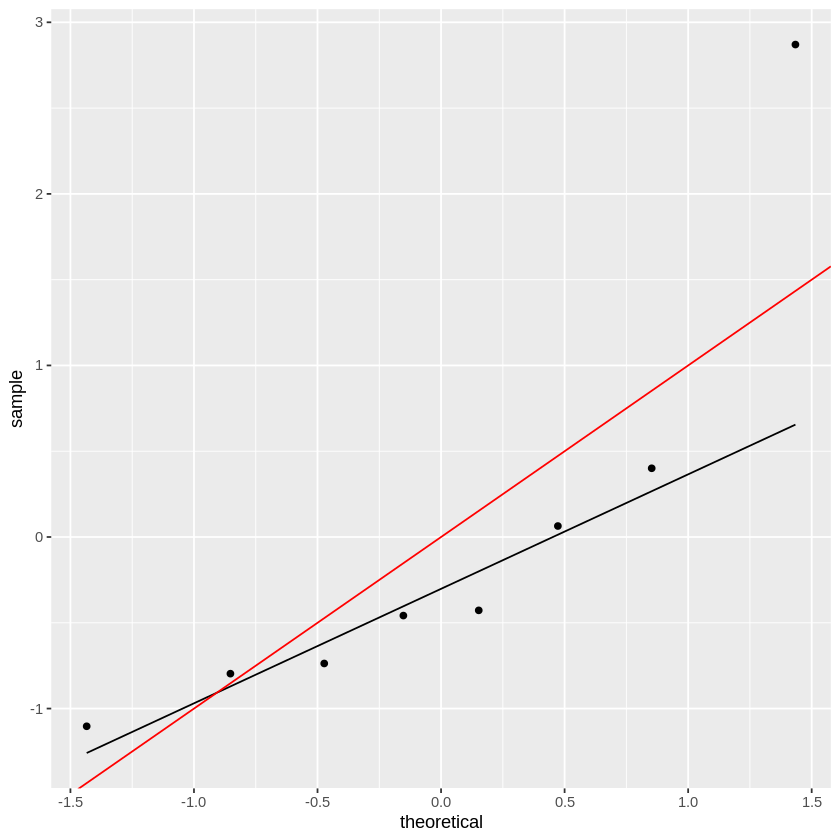

In [ ]:
# Denervated forelimb data distribution
denervated_df %>%
  filter(limb=='forelimb') %>% 
  ggplot(aes(sample=normalized_edu)) + 
  geom_qq() + geom_qq_line() + 
  geom_abline(slope=1, intercept=0, color='red')
ks.test(x=denervated_df$normalized_edu[denervated_df$limb=='forelimb'], y='pnorm', 0, 1, alternative='two.sided', exact=TRUE)


	One-sample Kolmogorov-Smirnov test

data:  denervated_df$normalized_edu[denervated_df$limb == "hindlimb"]
D = 0.17754, p-value = 0.9266
alternative hypothesis: two-sided


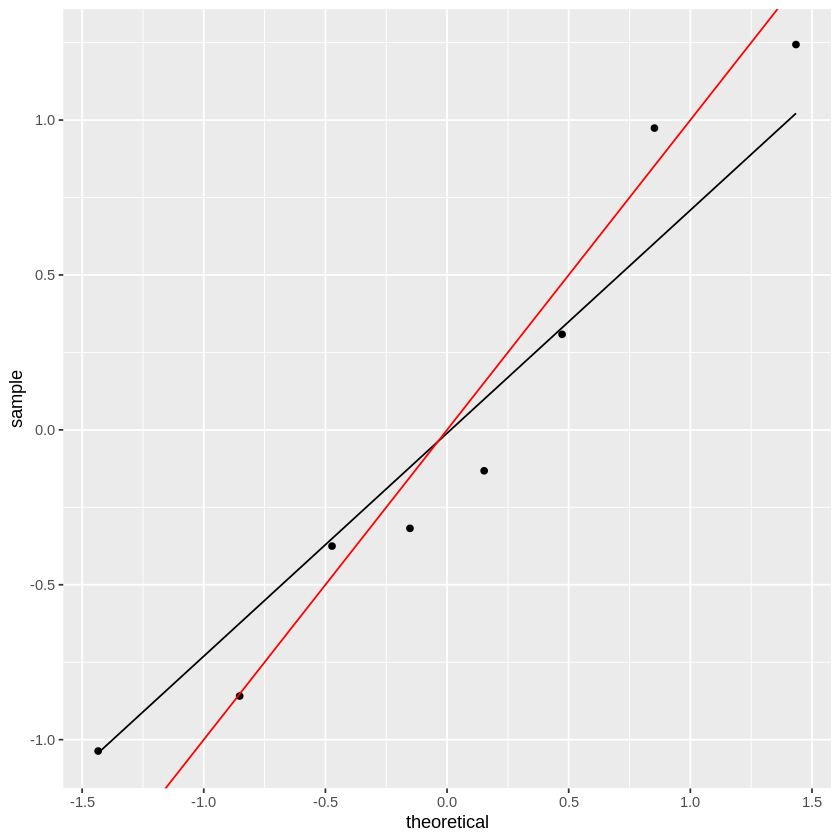

In [ ]:
# Denervated hindlimb data distribution
denervated_df %>%
  filter(limb=='hindlimb') %>% 
  ggplot(aes(sample=normalized_edu)) + 
  geom_qq() + geom_qq_line() + 
  geom_abline(slope=1, intercept=0, color='red')
ks.test(x=denervated_df$normalized_edu[denervated_df$limb=='hindlimb'], y='pnorm', 0, 1, alternative='two.sided', exact=TRUE)


	One-sample Kolmogorov-Smirnov test

data:  sham_agg_df$normalized_edu
D = 0.18344, p-value = 0.8718
alternative hypothesis: two-sided


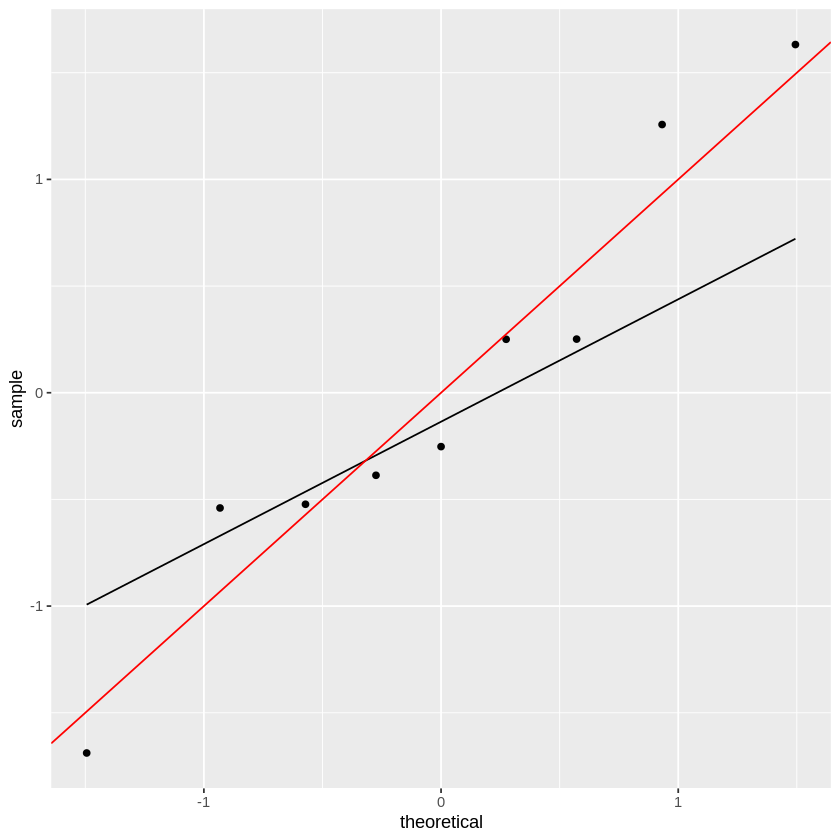

In [ ]:
# Sham mean-aggregated data distribution
sham_agg_df %>%
  ggplot(aes(sample=normalized_edu)) + 
  geom_qq() + geom_qq_line() + 
  geom_abline(slope=1, intercept=0, color='red')
ks.test(x=sham_agg_df$normalized_edu, y='pnorm', 0, 1, alternative='two.sided', exact=TRUE)


	One-sample Kolmogorov-Smirnov test

data:  denervated_agg_df$normalized_edu
D = 0.2268, p-value = 0.6643
alternative hypothesis: two-sided


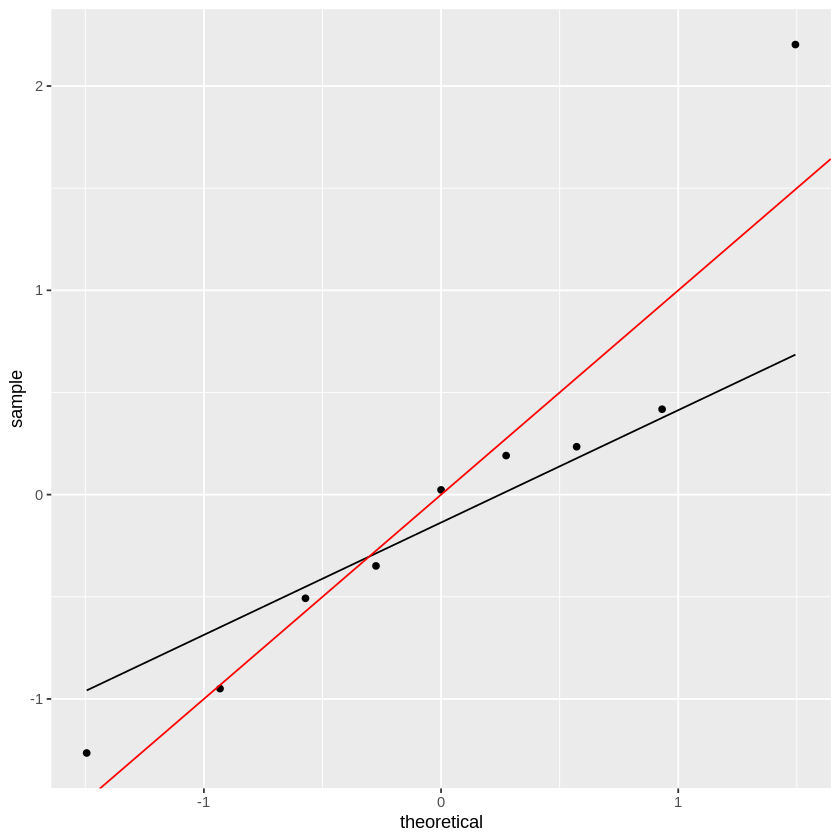

In [ ]:
# Denervated mean-aggregated data distribution
denervated_agg_df %>%
  ggplot(aes(sample=normalized_edu)) + 
  geom_qq() + geom_qq_line() + 
  geom_abline(slope=1, intercept=0, color='red')
ks.test(x=denervated_agg_df$normalized_edu, y='pnorm', 0, 1, alternative='two.sided', exact=TRUE)

# Power analysis for Welch t-test using normal data-generating process

In [ ]:
# Range of variation of the different parameters
n_range = 2:40
mu_sham_range = c(7,8,9,10)
sd_sham_range = c(3,4,5,7)
mu_denerve_range = c(1,2,3,4)
sd_denerve_range = c(1,2,3)
N_rep = 1000
alpha = 0.05

In [ ]:
# Create empty dataframe to store power calculations
power_df = expand.grid(mu_sham_range,sd_sham_range,mu_denerve_range,sd_denerve_range,n_range)
power_df['power'] = 0
colnames(power_df) = c('mu_sham','sd_sham','mu_denerve','sd_denerve','n','power')
head(power_df)

,mu_sham,sd_sham,mu_denerve,sd_denerve,n,power
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,7,3,1,1,2,0
2,8,3,1,1,2,0
3,9,3,1,1,2,0
4,10,3,1,1,2,0
5,7,4,1,1,2,0
6,8,4,1,1,2,0


In [ ]:
# Power analysis
set.seed(13)
for(i in 1:dim(power_df)[1]){

  # Define parameters
  mu_sham = power_df[i,'mu_sham']
  sd_sham = power_df[i,'sd_sham']
  mu_denerve = power_df[i,'mu_denerve']
  sd_denerve = power_df[i,'sd_denerve']
  n = power_df[i,'n']

  # Compute power
  pow = 0
  for(k in 1:N_rep){
    X_sham = rnorm(n, mean = mu_sham, sd = sd_sham)
    X_denerve = rnorm(n, mean = mu_denerve, sd = sd_denerve)
    pow = pow + (t.test(X_sham, X_denerve, alternative='two.sided', mu=0, paired=FALSE, var.equal=FALSE)$p.value < alpha)
  }
  
  # Update power_df
  power_df[i,'power'] = pow/N_rep

  # Print progress
  #print(paste0('progress = ',as.character(i/dim(power_df)[1])))
}

In [ ]:
# Reformat power_df
power_df_spread = power_df %>% spread(key=n, value=power)
power_df_spread

mu_sham,sd_sham,mu_denerve,sd_denerve,2,3,4,5,6,7,⋯,31,32,33,34,35,36,37,38,39,40
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,3,1,1,0.203,0.527,0.765,0.908,0.971,0.992,⋯,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
7,3,1,3,0.104,0.359,0.618,0.755,0.860,0.932,⋯,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
7,3,4,1,0.103,0.219,0.329,0.399,0.520,0.586,⋯,0.999,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
7,3,4,3,0.055,0.124,0.184,0.254,0.317,0.370,⋯,0.973,0.970,0.975,0.979,0.981,0.992,0.989,0.991,0.988,0.993
7,7,1,1,0.119,0.178,0.235,0.336,0.387,0.463,⋯,0.995,0.995,0.998,0.999,0.999,1.000,1.000,0.999,0.999,0.998
7,7,1,3,0.065,0.186,0.224,0.313,0.406,0.459,⋯,0.991,0.991,0.995,0.998,0.997,0.996,0.995,0.997,0.998,0.999
7,7,4,1,0.068,0.093,0.112,0.110,0.132,0.156,⋯,0.648,0.656,0.670,0.687,0.697,0.691,0.691,0.714,0.732,0.753
7,7,4,3,0.040,0.069,0.102,0.117,0.152,0.163,⋯,0.552,0.602,0.560,0.586,0.646,0.654,0.670,0.666,0.679,0.675
10,3,1,1,0.356,0.769,0.967,0.997,1.000,1.000,⋯,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [ ]:
# Plot for a particular configuration
config_mu_sham = 8
config_sd_sham = 5
config_mu_denerve = 2
config_sd_denerve = 2
power_df %>% 
  filter(mu_sham == config_mu_sham &
         sd_sham == config_sd_sham &
         mu_denerve == config_mu_denerve &
         sd_denerve == config_sd_denerve) %>%
  ggplot(aes(x=n, y=power)) +
  geom_line()+
  geom_hline(yintercept=0.8, col = 'grey')+
  xlab('number of animals')+
  ylab('power')

ERROR: ignored

# Power analysis for Welch t-test using effect sizes

In [ ]:
# Level of test
alpha = 0.05 # can choose 0.1, 0.05, 0.01
# Range of hypothesized effect sizes
ES_range = c(1,2,3,4)
# Range of sample sizes considered (number of animals)
n_range = 2:40

In [ ]:
 # Compute standard deviations from aggregated pilot study data
(sigma_sham_agg = sd(sham_agg_df$mean_edu))
(sigma_denerve_agg = sd(denervated_agg_df$mean_edu))

[1] 4.047409

[1] 1.826158

In [ ]:
# Compute power
l_power = list()
for (ES_hyp in ES_range) {
  power = c()
  for (n in n_range) {
    df = (n-1)*(sigma_sham_agg^2+sigma_denerve_agg^2)^2/(sigma_sham_agg^4+sigma_denerve_agg^4)
    t_critical = qt(p=1-alpha/2, df=df)
    power = c(power, pt(-t_critical+sqrt(n/2)*ES_hyp,df)+pt(-t_critical-sqrt(n/2)*ES_hyp,df))
  }
  l_power[[paste('ES_hyp',as.character(ES_hyp),sep='_')]] = power
}

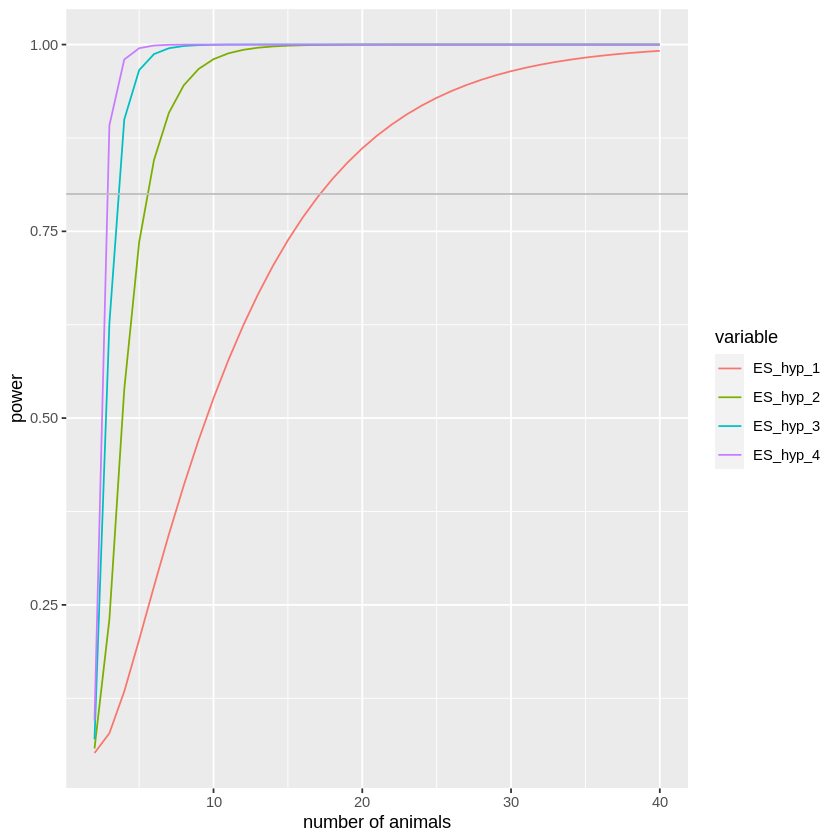

In [ ]:
# Plot plower
power_df_4 = as.data.frame(l_power)
power_df_4['n_animals'] = n_range
dataf = melt(power_df_4, 'n_animals')
dataf %>%
  ggplot(aes(x=n_animals, y=value, color=variable))+
  geom_line()+
  geom_hline(yintercept=0.8, col = 'grey')+
  xlab('number of animals')+
  ylab('power')